<a href="https://colab.research.google.com/github/kashindra-mahato/Computer-Vision/blob/main/Image_Classification_via_Fine_Tuning_with_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21834768/21834768 [==============================] - 0s 0us/step


In [ ]:
# IMG_SIZE is determined by Efficient model choice
IMG_SIZE = 224

In [ ]:
import tensorflow as tf

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
  print("Device:", tpu.master())
  strategy = tf.distribute.TPUStrategy(tpu)

except ValueError:
  print("Not connected to a TPU runtime. Using CPU/GPU strategy")
  strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"

(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteIW4SBU/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteIW4SBU/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

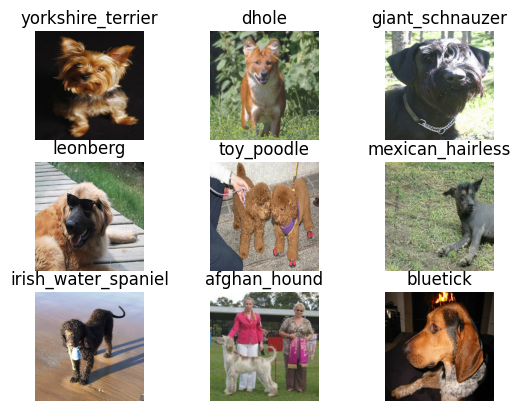

In [ ]:
import matplotlib.pyplot as plt

def format_label(label):
  string_label = label_info.int2str(label)
  return string_label.split("-")[1]

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title("{}".format(format_label(label)))
  plt.axis("off")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

In [ ]:
ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train =  ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [ ]:
## Training a model from scratch

In [ ]:
# from tensorflow.keras.applications import EfficientNetB0

# with strategy.scope():
#   inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#   x = img_augmentation(inputs)
#   outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

#   model = tf.keras.Model(inputs, outputs)
#   model.compile(
#       optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
#   )

# model.summary()

# epochs = 1 # in tutorial it is 40
# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

In [ ]:
# import matplotlib.pyplot as plt

# def plot_hist(hist):
#   plt.plot(hist.history["accuracy"])
#   plt.plot(hist.history["val_accuracy"])
#   plt.title("model accuracy")
#   plt.ylabel("accuracy")
#   plt.xlabel("epoch")
#   plt.legend(["train", "validation"], loc="upper left")
#   plt.show()

In [ ]:
## Transfer learning from pre-trained weights

In [ ]:
def build_model(num_classes):
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation(inputs)
  model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=['Accuracy']
  )
  return model

In [ ]:
with strategy.scope():
  model = build_model(num_classes=NUM_CLASSES)

epochs = 8 # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Epoch 1/8
187/187 - 62s - loss: 3.2397 - Accuracy: 0.4248 - val_loss: 0.8433 - val_Accuracy: 0.7414 - 62s/epoch - 332ms/step
Epoch 2/8
187/187 - 38s - loss: 1.6528 - Accuracy: 0.5820 - val_loss: 0.7205 - val_Accuracy: 0.7775 - 38s/epoch - 205ms/step
Epoch 3/8
187/187 - 39s - loss: 1.3238 - Accuracy: 0.6303 - val_loss: 0.6877 - val_Accuracy: 0.7937 - 39s/epoch - 208ms/step
Epoch 4/8
187/187 - 38s - loss: 1.2242 - Accuracy: 0.6532 - val_loss: 0.6977 - val_Accuracy: 0.7912 - 38s/epoch - 206ms/step
Epoch 5/8
187/187 - 39s - loss: 1.1876 - Accuracy: 0.6637 - val_loss: 0.6981 - val_Accuracy: 0.7959 - 39s/epoch - 207ms/step
Epoch 6/8
187/187 - 39s - loss: 1.1540 - Accuracy: 0.6687 - val_loss: 0.7261 - val_Accuracy: 0.7894 - 39s/epoch - 208ms/step
Epoch 7/8
187/187 - 39s - loss: 1.1204 - Accuracy: 0.6787 - val_loss: 0.7053 - val_Accuracy: 0.7954 - 39s/epoch - 208ms/step
Epoch 8/8
187/187 - 39s - loss: 1.1221 - Accuracy: 0.6784 - val_loss: 0.7428 - val_Accuracy: 0.7804 - 39s/epoch - 207ms/step


In [ ]:
# plot_hist(hist)

In [ ]:
def unfreeze_model(model):
  # We unfreeze the top 5 layers while leaving BatchNorm layers frozen
  for layer in model.layers[-5:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy']
  )

unfreeze_model(model)

epochs = 8 # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Epoch 1/8
187/187 - 48s - loss: 0.9530 - accuracy: 0.7193 - val_loss: 0.6651 - val_accuracy: 0.8020 - 48s/epoch - 258ms/step
Epoch 2/8
187/187 - 44s - loss: 0.8902 - accuracy: 0.7342 - val_loss: 0.6348 - val_accuracy: 0.8088 - 44s/epoch - 235ms/step
Epoch 3/8
187/187 - 39s - loss: 0.8669 - accuracy: 0.7392 - val_loss: 0.6176 - val_accuracy: 0.8133 - 39s/epoch - 207ms/step
Epoch 4/8
187/187 - 39s - loss: 0.8424 - accuracy: 0.7480 - val_loss: 0.6081 - val_accuracy: 0.8140 - 39s/epoch - 207ms/step
Epoch 5/8
187/187 - 40s - loss: 0.8089 - accuracy: 0.7561 - val_loss: 0.5997 - val_accuracy: 0.8179 - 40s/epoch - 213ms/step
Epoch 6/8
187/187 - 39s - loss: 0.8124 - accuracy: 0.7524 - val_loss: 0.5949 - val_accuracy: 0.8184 - 39s/epoch - 207ms/step
Epoch 7/8
187/187 - 45s - loss: 0.7779 - accuracy: 0.7672 - val_loss: 0.5894 - val_accuracy: 0.8207 - 45s/epoch - 240ms/step
Epoch 8/8
187/187 - 39s - loss: 0.7838 - accuracy: 0.7629 - val_loss: 0.5867 - val_accuracy: 0.8226 - 39s/epoch - 208ms/step
